In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from print_color import print

# Preprocessing

In [2]:
df = pd.read_csv('data/chessDataFinal.csv')[:50000] # This shuffles the rows
df

,fen,score
0,5rk1/pb1pnppp/3Q2q1/b3P3/2B5/5N2/P4PPP/R4RK1 w...,+276
1,b1r5/3nk2p/R7/4p1p1/1PN1P3/2BP4/7P/6K1 w - - 8 59,+451
2,5k2/5p2/3p2p1/2p4q/p1P5/P3P2K/5QP1/3R4 w - - 1 34,-317
3,r5k1/pp2qrpp/4Pp2/2bp4/2p2P2/2Q5/PP4KP/nNB1R3 ...,-594
4,2nk3r/2p3pp/3p1p2/P2Q4/3P4/q4N2/4RKP1/8 w - - ...,+281
...,...,...
49995,r7/2q2PkB/p2b4/3p3r/bp5R/8/PPPQ3P/2KR4 b - - 0 26,-95
49996,8/7R/8/8/P2p1p2/P2k4/r7/5K2 b - - 4 52,-591
49997,4RQ2/1p4kp/p5p1/3p2q1/nP6/7P/2r5/7K b - - 3 38,#+0
49998,3r1rk1/bb4pp/p1nqp3/1p3p1Q/5N2/1N2P1P1/PP3PBP/...,+117


In [3]:
encoder_object = ChessEncoder()

In [5]:
fen_encodings = []
for fen_i in df['fen']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [6]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [7]:
X

tensor([[ 0,  0,  0,  ...,  0, 30, 28],
        [10,  0,  9,  ...,  0, 15, 14],
        [ 0,  0,  0,  ...,  0, 18, 14],
        ...,
        [ 0,  0,  0,  ...,  0, 16, 22],
        [ 0,  0,  0,  ...,  0, 34, 34],
        [ 0,  0,  9,  ...,  0, 25, 25]], dtype=torch.int32)

In [8]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings, dtype=torch.float32)

In [9]:
X.shape, y.shape

(torch.Size([50000, 200]), torch.Size([50000]))

# Helper Functions

In [10]:
val_split = 10000
test_split = 10000

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.float32)
    return x, y
# b = get_batch(X, y, 64)

In [13]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:val_split+test_split].to(device)
y_test = y[val_split:val_split+test_split].to(device)
X = X[val_split+test_split:]
y = y[val_split+test_split:]

In [14]:
len(X)

30000

# Training

In [15]:
# hyperparameters
lr = 5e-2
num_steps = 500
warmup_steps = 20
bs_train = len(X)
bs_eval = 10000
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs_train > len(X): bs_train = len(X)

In [16]:
 # i accidenly used a smaller lr for scheduler and it worked better, maybe try it?

In [17]:
model = MLPEngine(embedding_dim=64, bs_train = bs_train, bs_eval=bs_eval).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(
            model.parameters(), 
            lr = lr,
            betas=(0.9, 0.999),
            eps=1e-3,
            weight_decay=1e-5)

# Define warm-up and decay
def lr_lambda(epoch):
    if epoch < warmup_steps:  
        return epoch / warmup_steps
    else:  # Exponential decay after warm-up
        return 0.99 ** (epoch - warmup_steps)

scheduler = LambdaLR(optimiser, lr_lambda)
model.compile()

In [18]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')

In [19]:
train_history = {}
val_history = {}
start_step = 0

In [20]:
model.train()
for step_i in range(1, num_steps+1):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs_train) 
    y_pred = model(x_batch).view(bs_train)
    loss = loss_category(y_pred, y_batch)
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0:
        # validation phase
        model.eval()
        y_pred = model(X_val).view(val_split)
        loss = loss_category(y_pred, y_val)
        val_history[tot_step] = loss.item()
        print(f'{tot_step}: {loss.item()} (Validation)', color='r')
        model.train()

start_step += num_steps

1 :  3532418.75
2 :  3634497.75
3 :  3619843.75
4 :  3639595.75
5 :  3499152.25
6 :  3533998.25
7 :  3647203.5
8 :  3465449.75
9 :  3527344.0
10 :  3653825.25
11 :  3580435.0
12 :  3532004.75
13 :  3490791.75
14 :  3341348.0
15 :  3329824.0
16 :  3503665.5
17 :  3414791.5
18 :  3489915.5
19 :  3513095.0
20 :  3339908.5
21 :  3350167.75
22 :  3231108.0
23 :  3345125.75
24 :  3313644.5
25 :  3247240.25
26 :  3193251.0
27 :  3065075.0
28 :  3182549.25
29 :  3067622.25
30 :  3010512.75
31 :  2982071.75
32 :  2921558.5
33 :  2871299.0
34 :  2793339.75
35 :  2735620.25
36 :  2808938.25
37 :  2583271.75
38 :  2667412.0
39 :  2720585.5
40 :  2481433.75
41 :  2479590.75
42 :  2486109.0
43 :  2313442.5
44 :  2311592.25
45 :  2210536.5
46 :  2363930.25
47 :  2156791.5
48 :  2000929.375
49 :  2095374.125
50 :  2181950.75
51 :  1850486.25
52 :  1844761.125
53 :  1778510.0
54 :  1745290.75
55 :  1684427.875
56 :  1692454.875
57 :  1590808.0
58 :  1568841.625
59 :  1341904.75
60 :  1429848.75
61 :  1

In [21]:
torch.save(model.state_dict(), 'saves/model2.pt')

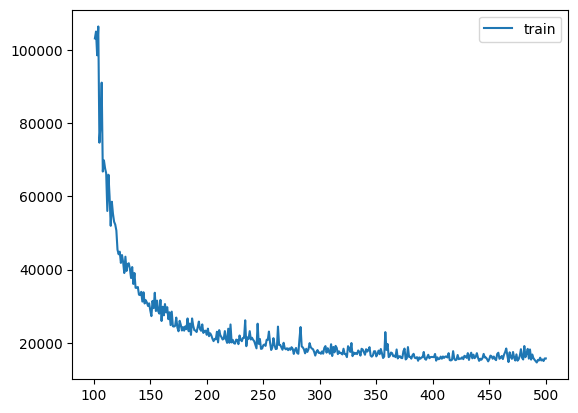

In [22]:
plt.plot(list(train_history.keys())[100:], list(train_history.values())[100:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

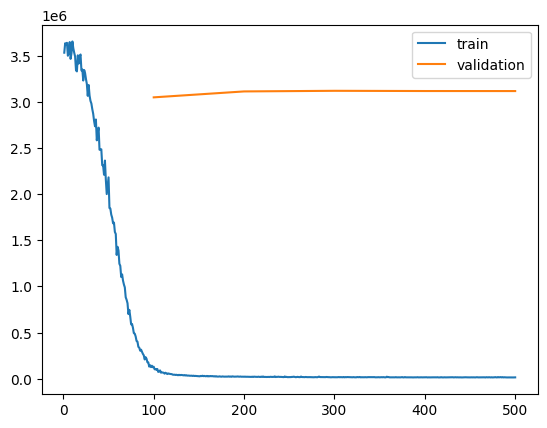

In [23]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [ ]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

# TO DO

- [x] do inference, and run a partially trained model with the GUI intact
- [x] **find a way to fix the fact that our model is giving integer loss
- [x] **Fix the bug in initialisation
- [ ] implement weights and biases or tensorboard 
- [ ] improve the model
  - [x] get a better/ bigger dataset
  - [ ] hyperparameter and architecture
    - [x] better encoding
    - [ ] residual connections
    - [ ] try adamW after tuning b1 and b2
    - [x] increase embedding dim
    - [x] increase neurons in the layers
    - [x] increase layers in the network
    - [x] change loss function (maybe)
    - [ ] try diff learning rate scheduler(trapeziodal)
    - [ ] Add regularisation
      - [ ] l1,l2
      - [x] dropout
    - [x] Better initialisation
    - [x] diff optimisation algorithm

# Note